# Create components in the PF coil group

The "PF coil group" is just a convention used in this package. It contains:
- The superconductor component (PFCoilMagnet)
- The thermal insulation component (PFCoilInsulation)
- The case/structure body component (PFCoilCase)

The Central Solenoid components can be built in exactly the same way

In [1]:
import openmc
import tokamak_radiation_environment as tre
import matplotlib.pyplot as plt

### Disclaimer 

Leghts are in [cm]

All the components proposed here are built with the [openmc.model.Polygon](https://docs.openmc.org/en/stable/pythonapi/generated/openmc.model.Polygon.html?highlight=polygon) class of openmc. It is then possible to directly use that class for more versatility already.

The [openmc.model.Polygon](https://docs.openmc.org/en/stable/pythonapi/generated/openmc.model.Polygon.html?highlight=polygon) class requires a list of points coordinates that will be connected by lines. Coordinates are given by a couple of floating numbers and can refer to any of the 'xy', 'xz', 'yz' or 'rz' planes. The polygon gets then 'extruded' on the direction perpendicular to the reference plane for an undefined extension. In the case of 'rz' plane the extrusion is revolved around the z plane which is helpful in order to design toroidal geometries.

In [2]:
# import materials
ss316L = tre.materials.ss316L
windingpack = tre.materials.windingpack
fiberglass = tre.materials.fiberglass

## Component objects

All the components have a "angle" argument that allows the user build just a slice of the tokamak using cutter planes perpendicular to the 'xy' plane. The angle must be a tuple of two angles defined in degrees.

The PFCoilMagnet component needs the nodes coordinates (in 'rz' plane by default) for the magnet boundary. All the other components take the magnet nodes and offset them autwards according to their thickness provided by the user.

We here provide an easy example with the ARC-class nodes.

In [3]:
pf_nodes = (
    [1165, 195],
    [1165, 225],
    [1135, 225],
    [1135, 195]
)

#### Magnet component

In [4]:
pf_magnet = tre.components.PFCoilMagnet(nodes=pf_nodes, material=windingpack, angle=None)

In OpenMC with constructive solid geometry every body has its surfaces, its region and its cell. With 'tre' it is possible to extract all of them. Cells being the most important for the simulation.

In [5]:
print(f'Surfaces: {pf_magnet.surfaces}')
print(f'Region: {pf_magnet.region}')
print(f'Cell: {pf_magnet.cell}')

Surfaces: <Polygon at 0x7f141840a5c0>
Segion: ((-5 -6 7 8))
Sell: Cell
	ID             =	1
	Name           =	
	Fill           =	Material 34
	Region         =	((-9 -10 11 12))
	Rotation       =	None
	Temperature    =	None
	Translation    =	None
	Volume         =	None



#### Insulation component

The insulation uses the same magnet's nodes from which it adds the insulation thickness in order to find the outer insulation surface. It then requires the magnet component as argument in order to extract the nodes.

In [6]:
insulation = tre.components.PFCoilInsulation(pf_coil_magnet=pf_magnet, thickness=10, material=fiberglass, angle=None)

#### Case component
The case uses the same magnet's nodes from which it adds the insulation thickness and the case thickness in order to find the outer insulation surface. It then requires the magnet component and the insulation component as arguments in order to extract nodes and thickness.

In [7]:
case = tre.components.PFCoilCase(pf_coil_magnet=pf_magnet, thickness=20, material=ss316L, pf_coil_insulation=insulation, angle=None)

## PF coil group function
The PF coil group function helps to generate all the component objects in the PF coil in just one call. It can used as alternative to the workflow that builds component by component presented just above.
It is necessary to provide:
- The magnet componet nodes
- The magnet component material
- The insulation component thickness
- The insulation component material
- The case component thickness
- The case component material

In [8]:
magnet, insulation, case = tre.components.pfcoil_group(
    magnet_nodes=pf_nodes, magnet_material=windingpack,
    insulation_thickness=10, insulation_material=fiberglass,
    case_thickness=20, case_material=ss316L,
    angle=None)

### Collect the cells in openmc geometry

In [9]:
root = [pf_magnet.cell, insulation.cell, case.cell]

geometry = openmc.Geometry(root=root)

## Visualize geometry

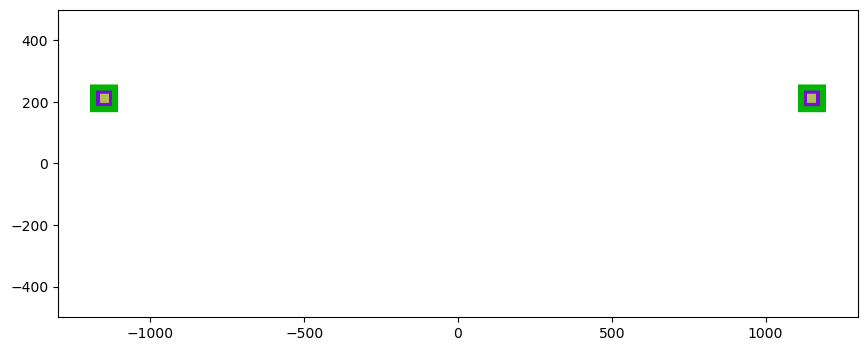

In [19]:
universe = openmc.Universe(cells=root)

universe.plot(basis='xz', width=[2600, 1000], pixels=[800, 800], color_by='cell')
plt.show()